In [ ]:
# скачиваем файл
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1VPkoWfiIvZl4HGp49BUaVEEblVIGYh91' -O heart.csv

In [3]:
import numpy as np
import pandas as pd

Мы будем работать с [данными о пациентах, у части которых есть заболевание сердца](https://www.kaggle.com/ronitf/heart-disease-uci).

In [4]:
data = pd.read_csv('heart.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [49]:
data.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Какой процент пациентов из представленных в данных имеет заболевание сердца (`'target' = 1`)?

In [5]:
data[data['target']==1].count()/data.count()

age         0.544554
sex         0.544554
cp          0.544554
trestbps    0.544554
chol        0.544554
fbs         0.544554
restecg     0.544554
thalach     0.544554
exang       0.544554
oldpeak     0.544554
slope       0.544554
ca          0.544554
thal        0.544554
target      0.544554
dtype: float64

Разделим данную выборку на обучающую и тестовую части в отношении 3:1.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1), data['target'], test_size=0.25, random_state=13)
X_train.shape, X_test.shape

((227, 13), (76, 13))

Обучение линейного классификатора из `sklearn` (`sklearn.linear_model.SGDClassifier`) с максимальным числом итераций `max_iter=1000`, постоянным значением шага градиентного спуска (`learning_rate='constant'`), равным `eta0=0.1`. Параметр регуляризации отключен: `alpha=0`. Класс `sklearn.linear_model.SGDClassifier` объединяет в себе разные линейные модели - чтобы получить логистическую регрессию, зафиксирован параметр `loss='log'`.

In [7]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(max_iter=1000, learning_rate='constant', eta0=0.1, alpha=0, loss='log')

clf.fit(X_train, y_train)

SGDClassifier(alpha=0, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.1, fit_intercept=True, l1_ratio=0.15,
              learning_rate='constant', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=13, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [8]:
clf.intercept_

array([-1.15927929])

Какое значение L2-нормы вектора весов (без учета свободного коэффициента) у полученного линейного классификатора?

_Напоминание. L2-норма вектора $v = (v_1, \ldots, v_n)$ - это корень из суммы квадратов его элементов:_

$$
\|v\|_2 = \sqrt{\sum\limits_{i=1}^nv_i^2}
$$

In [10]:
np.sqrt(np.sum(np.square(clf.coef_)))

175.67735435821564

In [11]:
y_pred = clf.predict(X_test)

Какова доля правильных ответов классификатора на тестовой части выборки?

In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.618421052631579

Обучен классификатор с параметром регуляризации `alpha=0.1` и типом регуляризации `penalty='l1'`. Также вместо постоянного значения шага градиентного спуска использовано оптимальное (`learning_rate='optimal'`), которое, кстати, зависит от `alpha`. В данном случае значение начального шага градиентного спуска `eta0` никак не участвует в обучении.

In [13]:
clf2 = SGDClassifier(max_iter=1000, learning_rate='optimal', alpha=0.1, penalty='l1', loss='log')

clf2.fit(X_train, y_train)
y_pred2 = clf2.predict(X_test)
accuracy_score(y_test, y_pred2)

0.7631578947368421

Какова L2-норма вектора весов для полученного классификатора с использованием регуляризации?

In [14]:
np.sqrt(np.sum(np.square(clf2.coef_)))

10.429142228977847

Как полученные классификаторы предсказывают не классы, а вероятности классов?

Так как мы работаем с логистической регрессией, это можно сделать.

In [15]:
prob1 = clf.predict_proba(X_test)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, prob1[:,-1])

0.5697674418604651

In [16]:
prob2 = clf2.predict_proba(X_test)
roc_auc_score(y_test, prob2[:,-1])

0.8558844256518675

Какой признак является самым важным по мнению лучшей модели для принятия решения?

In [22]:
pd.DataFrame({
    'feature': X_train.columns,
    'importance': clf2.coef_[0,:]
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

,feature,importance
0,cp,9.260850
1,thalach,0.744678
2,sex,0.000000
3,fbs,0.000000
4,restecg,0.000000
5,exang,0.000000
6,slope,0.000000
7,chol,-0.015010
8,oldpeak,-0.259030
9,trestbps,-0.457738


Линейный классификатор "своими руками"

In [52]:
def log_loss(w, X, y):
    Q = np.log(1 + np.exp(-y * (X @ w))).mean()
    return Q

def log_loss_grad(w, X, y):
    Q_grad = - ((X * y.reshape(-1, 1)) / (1 + np.exp(y * (X @ w))).reshape(-1, 1)).mean(axis=0)
    return Q_grad

n = X_train.shape[0]
w_init = np.ones(X_train.shape[1]+1)
X_new = np.c_[np.ones(n), X_train]
y_new = y_train.to_numpy()

from sklearn.preprocessing import StandardScaler
X_sd = StandardScaler().fit_transform(X_new)

print(X_sd)

[[ 0.         -0.28903944  0.68849544 ... -0.60983972 -0.71231672
  -2.12305432]
 [ 0.         -0.28903944  0.68849544 ...  0.98135127  0.27363386
   1.11139757]
 [ 0.         -0.72427627  0.68849544 ...  0.98135127  1.25958444
   1.11139757]
 ...
 [ 0.          0.36381581 -1.45244244 ...  0.98135127 -0.71231672
  -0.50582838]
 [ 0.         -1.2683223  -1.45244244 ... -0.60983972 -0.71231672
  -0.50582838]
 [ 0.          0.58143422  0.68849544 ...  0.98135127  1.25958444
   1.11139757]]


In [55]:
def gradient_descent(X, y, w_init, n_steps, eta):
    w = w_init.copy()
    loss_array = [log_loss(w_init, X, y)]
    for _ in range(n_steps):
        w_grad = log_loss_grad(w, X, y)
        w -= eta * w_grad
        loss = log_loss(w, X, y)
        loss_array.append(loss)
    return w, loss_array

w, loss_array = gradient_descent(X_sd, y_new, w_init, n_steps=1000, eta=0.1)
print('Final weights:', w)
print('Final loss value:', loss_array[-1])

Final weights: [ 1.          0.31292932 -0.45286496  1.13411622 -0.54852191 -0.14068798
 -0.26363365  0.49949546  0.92207537 -0.6820101  -1.24477722  0.34259602
 -1.07023101 -0.97546343]
Final loss value: 0.4600906667324972


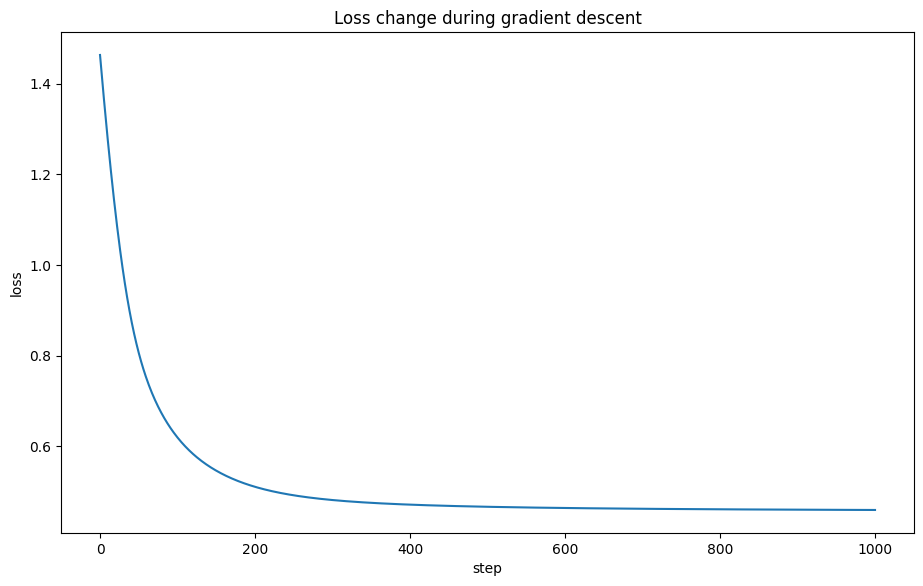

In [56]:
plt.figure(figsize=(11, 6.5))
plt.plot(loss_array)
plt.title('Loss change during gradient descent')
plt.xlabel('step')
plt.ylabel('loss')
plt.show()